In [1]:
%%capture
!pip install transformers wandb timm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
import os

print('Mounting Google Drive...')
drive.mount('/gdrive')

src_path = '/gdrive/MyDrive/shortcuts/project' #@param {type: 'string'}
assert os.path.exists(src_path), f"Source '{src_path}' doesn't exist!"

target_path = '.' #@param {type: 'string'}
os.makedirs(target_path, exist_ok=True)
assert os.path.exists(target_path), f"Target '{target_path}' doesn't exist!"

target_path = os.path.join(target_path, os.path.basename(src_path))
print(f'Copying from "{src_path}" to "{target_path}"...')
os.makedirs(target_path, exist_ok=True)
!cp -rf "$src_path"/* "$target_path"  # also work when source is a shortcut

Mounting Google Drive...
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Copying from "/gdrive/MyDrive/shortcuts/project" to "./project"...


In [4]:
!sudo tar -xvf  project/* 
pass

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/bench/source/.gitignore
BSR/bench/source/kofn.cc
BSR/bench/source/build.m
BSR/bench/source/Random.cc
BSR/bench/source/Point.hh
BSR/bench/source/README
BSR/bench/source/Matrix.hh
BSR/bench/source/csa.hh
BSR/bench/source/String.hh
BSR/bench/bench_bsds500.m
BSR/bench/data/
BSR/bench/data/groundTruth/
BSR/bench/data/groundTruth/6046.mat
BSR/bench/data/groundTruth/2018.mat
BSR/bench/data/groundTruth/8068.mat
BSR/bench/

In [5]:
from torch import nn
from transformers import TrainingArguments, Trainer, TrainerCallback
import wandb
import sys

In [6]:
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as TT
import torch

import numpy as np

from PIL import Image

import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
def plot_random_images(loader):

    n_images = 5

    _, axes = plt.subplots(figsize=(20, 5), ncols=n_images)

    model_input = iter(loader).next()

    for img_id, ax in zip(np.random.choice(model_input.shape[0], n_images, replace=False), axes.ravel()):
    
        ax.imshow(model_input[img_id].squeeze().permute(1, 2, 0).detach().cpu().numpy())
    
        ax.axis('off')

    plt.tight_layout()

In [8]:
train_path = 'BSR/BSDS500/data/images/train/'
test_path = 'BSR/BSDS500/data/images/test/'
val_path = 'BSR/BSDS500/data/images/test/'

In [9]:
TRAIN_SIZE = 432
VAL_SIZE = 68

In [10]:
train_pics_list = []

for pic_name in os.listdir(train_path):
    if pic_name.split('.')[-1] == 'jpg':
        train_pics_list.append(train_path + pic_name)

for pic_name in os.listdir(test_path):
    if pic_name.split('.')[-1] == 'jpg':
        train_pics_list.append(test_path + pic_name)

val_pics_for_train = []

for pic_name in os.listdir(val_path):

    if len(val_pics_for_train) == TRAIN_SIZE - len(train_pics_list):
        break
    
    if pic_name.split('.')[-1] == 'jpg':
        val_pics_for_train.append(val_path + pic_name)

train_pics_list += val_pics_for_train

assert len(train_pics_list) == TRAIN_SIZE

In [11]:
val_pics_list = []

remaining_pics_list = []

for pic_name in os.listdir(val_path):

    if len(val_pics_list) == VAL_SIZE:
        break
    
    if pic_name.split('.')[-1] == 'jpg':
        val_pics_list.append(val_path + pic_name)

assert len(val_pics_list) == VAL_SIZE

In [12]:
class ImageNoiseAdditor(object):
    def __init__(self, train_params, valid_params):
        '''
        train_params = dict(sigma_from: int [from 0 to 255], 
                            sigma_to: int [from 0 to 255])

        valid_params = dict(sigma: int(from 0 to 255))
        '''
        self.train_params = train_params
        self.valid_params = valid_params


    def apply(self, image, train=True):

        assert isinstance(image, Image.Image), colored(f'wrong type of image (wait {Image.Image})', 'red') + f' Got:{type(image)}'
        img_numpy = np.asarray(image).astype(float)
        # print(img_numpy.min(), img_numpy.max())
        
        if train:
            sigma = np.random.randint(low=self.train_params['sigma_from'], 
                                      high=self.train_params['sigma_to'])
        else:
            sigma = self.valid_params['sigma']
        
        n = np.random.randn(*img_numpy.shape)
        img_numpy += float(sigma) * n
        img_numpy = np.clip(img_numpy, 0, 255).astype(np.uint8)

        image_with_noise = Image.fromarray(img_numpy, mode='RGB')

        # fig, axs = plt.subplots(1, 2)
        # axs[0].imshow(image)
        # axs[1].imshow(image_with_noise)
        # plt.show()

        return image_with_noise

In [13]:
class BSDDataset(torch.utils.data.Dataset):
  def __init__(self, img_list, transform, height, width, sigma_val=50, train=False):
    super(BSDDataset, self).__init__()
    self.img_list = img_list
    self.transform = transform
    self.height = height
    self.width = width
    self.to_tensor = TT.Compose([TT.Resize((height, width)),
                                 TT.ToTensor()])
    
    self.noise = ImageNoiseAdditor(train_params=dict(sigma_from=10, sigma_to=55),
                                   valid_params=dict(sigma=sigma_val))
    
    self.train = train

  def get_rand_from_to(self, from_, to_):
      return np.random.randint(low=int(from_), high=int(to_))

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):

    img = Image.open(self.img_list[idx])
    img_with_noise = self.noise.apply(img, train=self.train)

    if np.random.choice([True, False]):
       img = torchvision.transforms.functional.hflip(img)
       img_with_noise = torchvision.transforms.functional.hflip(img_with_noise)

    w, h = img.size[:2]

    max_top = h / 2
    max_left = w / 2

    if h - self.height > 0:
        max_top = h - self.height
        top = self.get_rand_from_to(0, max_top)
        height = self.get_rand_from_to(self.height, h - top)
    else:
        top = self.get_rand_from_to(0, max_top)
        height = self.get_rand_from_to(h / 2, h - top)

    if w - self.width > 0:
        max_left = w - self.width
        left = self.get_rand_from_to(0, max_left)
        width = self.get_rand_from_to(self.width, w - left)
    else:
        left = self.get_rand_from_to(0, max_left)
        width = self.get_rand_from_to(w / 2, w - left)
    


    img = torchvision.transforms.functional.crop(img, top, left, height, width)
    img_with_noise = torchvision.transforms.functional.crop(img_with_noise, top, left, height, width)

    # if self.train:
        # angle = int(np.random.choice(np.arange(20)))
        # img = torchvision.transforms.functional.rotate(img, angle=angle)
        # img_with_noise = torchvision.transforms.functional.rotate(img_with_noise, angle=angle)
    
    return dict(inputs=self.to_tensor(img_with_noise), 
                labels=self.to_tensor(img))

In [14]:
upscale = 8
window_size = 8
height = (512 // upscale // window_size + 1) * window_size
width = (512 // upscale // window_size + 1) * window_size

random_transform = [
    TT.Compose([TT.RandomCrop(320, padding=0),
                        TT.Pad(2, padding_mode='reflect')]),
    TT.Compose([TT.RandomCrop(320, padding=0), 
            ]),
]

train_transform = TT.Compose([
    # TT.RandomHorizontalFlip(p=0.5), 
    # TT.RandomRotation(degrees=20),
    # TT.RandomChoice(random_transform),
    # TT.RandomChoice(random_transform),
    TT.Resize((height, width)),
    TT.ToTensor(), 
    # TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = TT.Compose([
    TT.Resize((height, width)),
    TT.ToTensor(),
    # TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = BSDDataset(train_pics_list, transform=train_transform, 
                       height=height, width=width, train=True)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)

val_set = BSDDataset(val_pics_list, transform=val_transform, 
                     height=height, width=width, sigma_val=50, train=True)

# val_set_50 = BSDDataset(val_pics_list, transform=val_transform, 
#                      height=height, width=width, sigma_val=50, train=False)

# val_set_15 = BSDDataset(val_pics_list, transform=val_transform, 
#                      height=height, width=width, sigma_val=15, train=False)

# val_set_25 = BSDDataset(val_pics_list, transform=val_transform, 
#                      height=height, width=width, sigma_val=25, train=False)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=32)

print('Train size', len(train_set))
print('Test size', len(val_set))


Train size 432
Test size 68


In [15]:

data = val_set.__getitem__(10)
data['inputs'].shape#, data[1].shape, data[0].min(), data[1].min(), data[0].max(), data[1].max()

torch.Size([3, 72, 72])

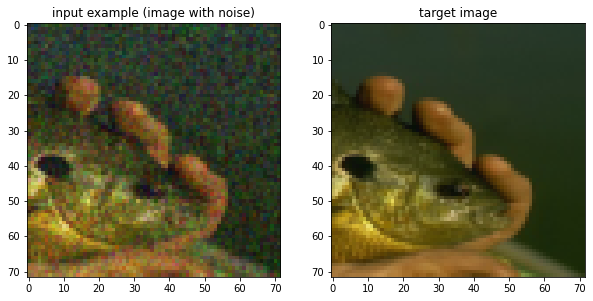

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(data['inputs'].cpu().detach().numpy().transpose(1, 2, 0))
axs[0].set_title('input example (image with noise)')
axs[1].imshow(data['labels'].cpu().detach().numpy().transpose(1, 2, 0))
axs[1].set_title('target image')
plt.show()

In [17]:
sys.path.append(os.path.join(os.path.dirname(sys.path[1]),'gdrive', 'MyDrive', 'ML_proj'))
from network_swinir import SwinIR
from termcolor import colored
from util_calculate_psnr_ssim import calculate_psnr, calculate_ssim

In [18]:
# img = Image.open(train_set.img_list[0])
# img_with_noise = train_set.noise.apply(img, train=train_set.train)

# # output = (output * 255.0).round().astype(np.uint8)
# # img_gt = (output * 255.0).round().astype(np.uint8)

# psnr = calculate_psnr(np.asarray(img_with_noise), 
#                       np.asarray(img), crop_border=0, input_order='HWC')
# # psnr_accumulator[b] = psnr

# ssim = calculate_ssim(np.asarray(img_with_noise), 
#                       np.asarray(img), crop_border=0, input_order='HWC')
# # ssim_accumulator[b] = ssim

# ssim, psnr

In [19]:
# np.asarray(img_with_noise).shape, np.asarray(img_with_noise).min(), np.asarray(img_with_noise).max()

In [20]:
# print('Train (augmented) images.')
# plot_random_images(train_loader)

# print('Test images (no augmentation).')
# plot_random_images(val_loader)

In [21]:


model = SwinIR(upscale=1, img_size=(height, width),
               window_size=window_size, img_range=1.,
               depths=[6, 6, 6, 6], embed_dim=120, num_heads=[6, 6, 6, 6], 
               mlp_ratio=4, upsampler=None, resi_connection='3conv')

# print(model)
# print(height, width, model.flops() / 1e9)

# x = torch.unsqueeze(data['inputs'], 0)
# y = model(x)
# print(x.shape, y.shape)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [22]:
class  CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3):
        super().__init__()
        self.eps = eps
        self.l2 = torch.nn.MSELoss()

    def forward(self, I_pred, I_traget):
        x = torch.sqrt(self.l2(I_pred, I_traget) + self.eps ** 2)
        return x

In [23]:
lr = 0.5 * 1e-5
epochs = 400
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=epochs, 
                                                       eta_min=0, 
                                                       last_epoch=- 1, 
                                                       verbose=False)

criterion = CharbonnierLoss()#torch.nn.L1Loss()

In [24]:
mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
mem = mem_params + mem_bufs # in bytes
print(mem)

34925772


In [ ]:
calculate_psnr(img_origin, img_gt, crop_border=0, input_order='HWC')

In [25]:
def compute_metrics(EvalPredict):
    
    predictions, label_ids = EvalPredict
    batch_size = predictions.shape[0]
    psnr_accumulator = np.zeros(batch_size)
    ssim_accumulator = np.zeros(batch_size)

    for b in range(batch_size):

        output = predictions[b]
        img_gt = label_ids[b]

        output = (output * 255.0).round().astype(np.uint8).transpose(1, 2, 0)
        img_gt = (img_gt * 255.0).round().astype(np.uint8).transpose(1, 2, 0)

        psnr = calculate_psnr(output, img_gt, crop_border=0, input_order='HWC')
        psnr_accumulator[b] = psnr

        ssim = calculate_ssim(output, img_gt, crop_border=0, input_order='HWC')
        ssim_accumulator[b] = ssim

    return {'psnr': psnr_accumulator.mean(), 'ssim': ssim_accumulator.mean()}



class CustomTrainer(Trainer):
    def __init__(self, loss, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss = loss

    def compute_loss(self, model, inputs, return_outputs=False):
        inp_, labels = inputs['inputs'], inputs['labels']
        # forward pass
        outputs = model(inp_)

        # compute custom loss (suppose one has 3 labels with different weights)
        loss = self.loss(outputs, labels)
        return (loss, outputs) if return_outputs else loss


class ModelTestCallback(TrainerCallback):
    def __init__(self, eval_data_set, **kwargs):
        super().__init__(**kwargs)
        self.eval_data_set = eval_data_set

    def on_evaluate(self, args, state, control, **kwargs): # on_evaluate, on_epoch_begin
        print(colored('Callback', 'green', attrs=['bold']))
        caption = ['input', 'target', 'output']
        # print(kwargs)
        s_list = [15, 25, 50]
        for s in s_list:
            self.eval_data_set.noise.valid_params['sigma'] = s
            idx = np.random.randint(low=0, high=len(self.eval_data_set))
            data = self.eval_data_set.__getitem__(idx)
            
            
            inp, lbl = data['inputs'].to('cpu'), data['labels'].to('cpu')
            model = kwargs['model'].to('cpu')
            out = model(torch.unsqueeze(inp, dim=0))
            

            inp = [Image.fromarray((inp.cpu().detach().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))]
            lbl = [Image.fromarray((lbl.cpu().detach().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))]
            out = [Image.fromarray((out[0].cpu().detach().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))]
            
            wandb.log({f"examples sigma = {self.eval_data_set.noise.valid_params['sigma']}": [wandb.Image(img, caption=caption[i]) for i, img in enumerate(inp + lbl + out)]})

            del inp, lbl, out


        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        kwargs['model'].to(device)


In [45]:
batch_size = 10
batch_accumulation = 8
path_for_save = os.path.join(os.path.dirname(sys.path[1]),'gdrive', 'MyDrive', 'ML_proj', 'checkpoints')

args = TrainingArguments(output_dir=path_for_save,
                         overwrite_output_dir=True,
                         report_to='wandb',
                         evaluation_strategy='steps',
                         logging_steps=5,
                         gradient_accumulation_steps=batch_accumulation,
                         per_device_train_batch_size=batch_size,
                         num_train_epochs=epochs,
                         load_best_model_at_end=True,
                         metric_for_best_model='ssim',
                         greater_is_better=True,
                         no_cuda=False,
                         save_strategy='steps',
                         save_steps=5, 
                         save_total_limit=3,
                         ignore_data_skip=True,
                         resume_from_checkpoint=os.path.join(os.path.dirname(sys.path[1]),'gdrive', 'MyDrive', 'ML_proj', 'checkpoints', 'checkpoint-1220')
                         )


athlete = CustomTrainer(loss=criterion,
                        model=model, 
                        train_dataset=train_set,
                        eval_dataset=val_set,
                        compute_metrics=compute_metrics,
                        optimizers=(optimizer, scheduler),
                        # preprocess_logits_for_metrics=lambda x:x,
                        callbacks=[ModelTestCallback(eval_data_set=val_set)],
                        args=args)

using `logging_steps` to initialize `eval_steps` to 5
PyTorch: setting up devices


In [46]:
athlete.train(os.path.join(os.path.dirname(sys.path[1]),'gdrive', 'MyDrive', 'ML_proj', 'checkpoints', 'checkpoint-1220'))
# athlete.train()

Loading model from /gdrive/MyDrive/ML_proj/checkpoints/checkpoint-1220).
***** Running training *****
  Num examples = 432
  Num Epochs = 400
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 8
  Total optimization steps = 2000
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 244
  Continuing training from global step 1220
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


RuntimeError: ignored

In [34]:


help(athlete)

Help on CustomTrainer in module __main__ object:

class CustomTrainer(transformers.trainer.Trainer)
 |  CustomTrainer(loss, *args, **kwargs)
 |  
 |  Trainer is a simple but feature-complete training and eval loop for PyTorch, optimized for 🤗 Transformers.
 |  
 |  Args:
 |      model ([`PreTrainedModel`] or `torch.nn.Module`, *optional*):
 |          The model to train, evaluate or use for predictions. If not provided, a `model_init` must be passed.
 |  
 |          <Tip>
 |  
 |          [`Trainer`] is optimized to work with the [`PreTrainedModel`] provided by the library. You can still use
 |          your own models defined as `torch.nn.Module` as long as they work the same way as the 🤗 Transformers
 |          models.
 |  
 |          </Tip>
 |  
 |      args ([`TrainingArguments`], *optional*):
 |          The arguments to tweak for training. Will default to a basic instance of [`TrainingArguments`] with the
 |          `output_dir` set to a directory named *tmp_trainer* in the c

In [26]:
def load_model(checkpoint, model):
    print(colored('checkpoint:', 'grey', attrs=['bold']), checkpoint)

    state_dict = torch.load(os.path.join(checkpoint, 'pytorch_model.bin'), map_location="cpu")
    load_result = model.load_state_dict(state_dict, strict=False)

    print(load_result)

    return model

In [27]:
checkpoint = os.path.join(os.path.dirname(sys.path[1]),'gdrive', 'MyDrive', 'ML_proj', 'checkpoints', 'checkpoint-1220')
model = load_model(checkpoint, model)

checkpoint: /gdrive/MyDrive/ML_proj/checkpoints/checkpoint-1220
<All keys matched successfully>


In [28]:
from typing import Tuple
from tqdm.notebook import tqdm 


def valid_shape(img_size, model_img_shape):
    assert img_size[0] >= model_img_shape[0], colored("can't put image as input for model", 'red') + f' img_size = {img_size} < model_img_shape = {model_img_shape}'
    assert img_size[0] >= model_img_shape[1], colored("can't put image as input for model", 'red') + f' img_size = {img_size} < model_img_shape = {model_img_shape}'
    assert img_size[1] >= model_img_shape[0], colored("can't put image as input for model", 'red') + f' img_size = {img_size} < model_img_shape = {model_img_shape}'
    assert img_size[1] >= model_img_shape[1], colored("can't put image as input for model", 'red') + f' img_size = {img_size} < model_img_shape = {model_img_shape}'

def predict_on_image(img: Image.Image, model, model_img_shape: Tuple[int], steps: Tuple[int]) -> Image.Image:

    model.to('cpu')
    model.eval()
    valid_shape(img.size, model_img_shape)

    to_tensor = TT.ToTensor()
    img = to_tensor(img) # size now: c h w
    img = torch.unsqueeze(img, dim=0) # size now: b(=1) c h w

    total_output = torch.zeros_like(img).float()
    num_predicts = torch.zeros_like(img).float()

    step_h, step_w = steps
    for start_h in tqdm(range(0, img.shape[2], step_h)):
        for start_w in range(0, img.shape[3], step_w):
            end_h = start_h + model_img_shape[0]
            end_w = start_w + model_img_shape[1]

            if end_h > img.shape[2]:
                start_h = img.shape[2] - model_img_shape[0]
                end_h = img.shape[2]

            if end_w > img.shape[3]:
                start_w = img.shape[3] - model_img_shape[1]
                end_w = img.shape[3]

            input = img[:, :, start_h : end_h, start_w : end_w]

            with torch.no_grad():
                total_output[:, :, start_h : end_h, start_w : end_w] += model(input)
                num_predicts[:, :, start_h : end_h, start_w : end_w] += 1

    image_out = total_output / num_predicts
    image_out = Image.fromarray((image_out[0].cpu().detach().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

    return image_out

    

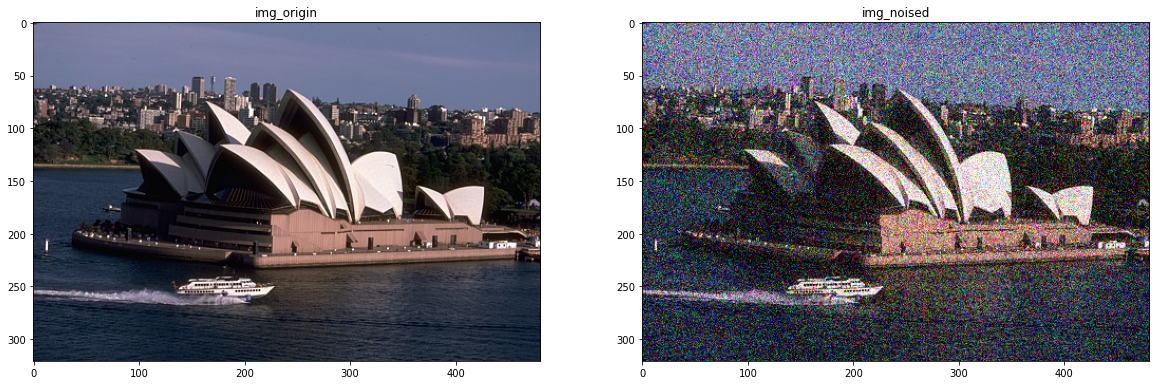

  0%|          | 0/11 [00:00<?, ?it/s]

In [33]:
noiser = ImageNoiseAdditor(train_params=dict(sigma_from=10, sigma_to=55),
                           valid_params=dict(sigma=50))

img_origin = Image.open('BSR/BSDS500/data/images/test/69000.jpg')
img_noised = noiser.apply(img_origin, train=False)


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img_origin)
axs[0].set_title('img_origin')

axs[1].imshow(img_noised)
axs[1].set_title('img_noised')

plt.show()

img_out = predict_on_image(img_noised, model, (height, width), steps=(30, 30))

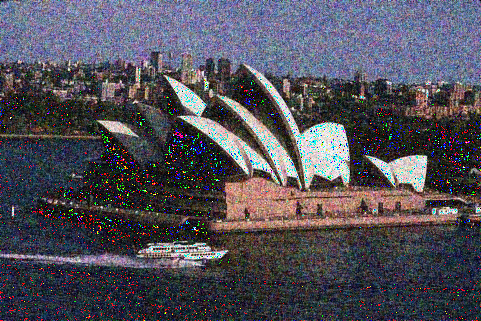

In [34]:
    img_out

In [35]:
img_out.save(checkpoint + '/ex_output_sigma50.png')
img_origin.save(checkpoint + '/ex_origin_sigma50.png')
img_noised.save(checkpoint + '/ex_noised_sigma50.png')